# **App 2: Traffic Volume Prediction**
Predict **traffic volume** given various measurements

In [43]:
# Import libraries

import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn
# from sklearn.ensemble import RandomForestRegressor # Random Forest -- shouldn't need this

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

In [44]:
# Import Data
df = pd.read_csv('Traffic_Volume.csv')

# Find out how many nulls in each val and then see if they're really null
# Let it know that "None" for holiday is a None not a null!
df['holiday'] = df['holiday'].replace({None: "None"})

# Dropping null values
df.dropna(inplace = True)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,None,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,None,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,None,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,None,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [45]:

# Make a copy to edit date and time to what I want
df_copy = df.copy()

# Make sure all the date_time entries are actually in date_time format
df_copy['date_time'] = pd.to_datetime(df['date_time'])

# Extract date/time to month and day of week and the hour and treat them as categorical
# Extract month
df_copy['month'] = df_copy['date_time'].dt.month_name()

# Extract day of the week
df_copy['weekday'] = df_copy['date_time'].dt.day_name()

# Extract hour
df_copy['hour'] = df_copy['date_time'].dt.hour.astype(str)

# drop original date_time column
df_copy.drop(['date_time'], axis=1, inplace=True)

# move traffic_volume to the end column
df_copy = df_copy[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'month', 'weekday', 'hour', 'traffic_volume']] 

df_copy.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,month,weekday,hour,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,October,Tuesday,9,5545
1,None,289.36,0.0,0.0,75,Clouds,October,Tuesday,10,4516
2,None,289.58,0.0,0.0,90,Clouds,October,Tuesday,11,4767
3,None,290.13,0.0,0.0,90,Clouds,October,Tuesday,12,5026
4,None,291.14,0.0,0.0,75,Clouds,October,Tuesday,13,4918


In [46]:
df_copy['holiday'].value_counts()

holiday
None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

In [47]:
df_copy.dtypes

holiday            object
temp              float64
rain_1h           float64
snow_1h           float64
clouds_all          int64
weather_main       object
month              object
weekday            object
hour               object
traffic_volume      int64
dtype: object

In [48]:
# Select input and output features
X = df.drop(columns = ['traffic_volume'])
y = df['traffic_volume']

In [49]:
# Output column for prediction
output = df_copy['traffic_volume']

# Input features (excluding traffic volume column)
features = df_copy[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'month', 'weekday', 'hour']] 

# One-hot encoding to handle categorical variables
cat_var = ['holiday', 'weather_main', 'month', 'weekday', 'hour']
features_encoded = pd.get_dummies(features, columns = cat_var)

features_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,288.28,0.0,0.0,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,289.36,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
# Make types compatible with xgboost (no objects allowed!)
# Convert all booleans to ints 0/1 so xgb can handle them
features_encoded = features_encoded.astype({col: 'int' for col in features_encoded.select_dtypes('bool').columns}) # source: chatgpt

# Check types again
features_encoded.dtypes


temp                     float64
rain_1h                  float64
snow_1h                  float64
clouds_all                 int64
holiday_Christmas Day      int64
                          ...   
hour_5                     int64
hour_6                     int64
hour_7                     int64
hour_8                     int64
hour_9                     int64
Length: 70, dtype: object

### Implement XGBoost

In [51]:
# Data partitioning into training and testing
train_X, test_X, train_y, test_y = train_test_split(features_encoded, output, test_size = 0.2, random_state = 1) 

from xgboost import XGBRegressor
# Defining prediction model: create an xgboost regression model
model = XGBRegressor(random_state = 42)

# Fitting model on training data
model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### Evaluate Prediction Performance on Test Set

In [52]:
# Predict Test Set
y_pred = model.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 436.33


#### Histogram of Residuals/Errors 

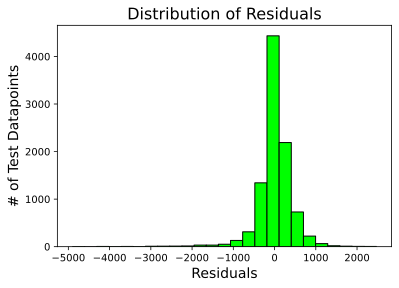

In [53]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig("residual_plot.svg")

#### Scatter Plot of Predicted Vs. Actual Values

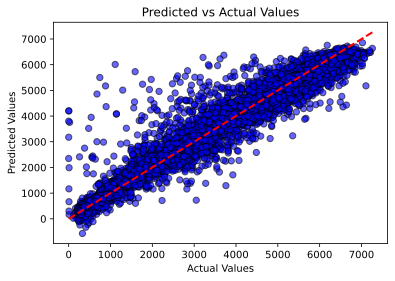

In [54]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig("pred_vs_actual.svg")

#### Feature Importance Plot

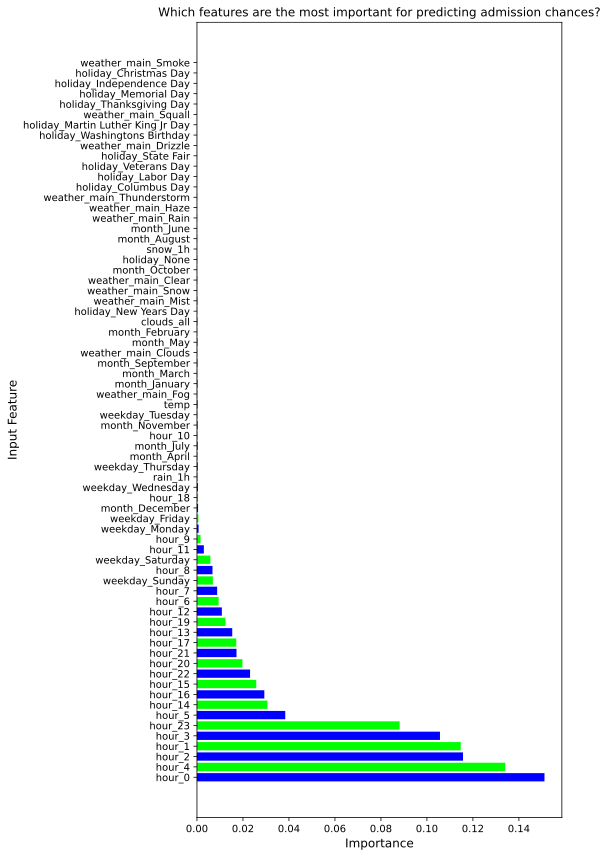

In [55]:
# Storing importance values from the trained model
importance = model.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 12))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['blue', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting admission chances?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();

plt.savefig("feature_imp.svg")

### Prediction Intervals for Regression

In [56]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = model, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 4.3906569480896s


In [57]:
# Predicted values
y_test_pred

# Prediction Intervals
y_test_pis

# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
36845,4720,4407.600098,3799.11,4992.05
9943,3185,2049.459961,1411.70,2607.82
19981,1741,1619.180054,1098.52,2294.63
19918,4611,4597.870117,3968.31,5157.73
28318,4556,4803.839844,4069.31,5366.01


### **Coverage Calculation**

In [58]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.15%


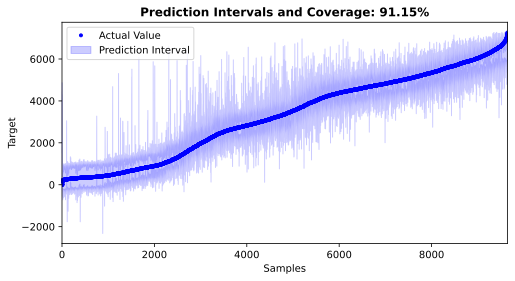

In [59]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'bo', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="blue", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig("coverage.svg")

### Save Model

In [60]:
# Creating the file where we want to write the model
xgb_pickle = open('xgb_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, xgb_pickle) 

# Close the file
xgb_pickle.close()